### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re 
import nltk
import matplotlib.pyplot as plt

nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/toanne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset_path = 'data/Twitter_Data.csv'
df = pd.read_csv(dataset_path)
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [3]:
df.describe()

,category
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


### Preprocessing

In [5]:
df = df.dropna()

In [6]:
def text_normalize(text):
    # Lowercase
    text = text.lower()

    # Retweet old acronym "RT" removal
    text = re.sub(r'^rt[\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Stopwords removal
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    
    # Stemming
    stemmer = SnowballStemmer('english')
    text = text.split()
    text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)

    return text

### Vectorize

In [7]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

In [8]:
# Add bias term
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)

In [9]:
# Encode labels to one-hot format
n_classes = df['category'].nunique() 
n_samples = df.shape[0]

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
y_encoded = np.zeros((n_samples, n_classes))
y_encoded[np.arange(n_samples), y] = 1

In [10]:
val_size = 0.2
test_size = 0.125
random_state = 2
X_train, X_val, y_train, y_val = train_test_split(X_b, y_encoded, test_size=val_size, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

In [11]:
def softmax(z):
    exps = np.exp(z)
    return exps / np.sum(exps, axis=1, keepdims=True)

def predict(X, theta):
    return softmax(np.dot(X, theta))

def compute_loss(y_hat, y):
    return -np.sum(y * np.log(y_hat)) / y.size

def compute_gradient(X, y, y_hat):
    return np.dot(X.T, y_hat - y) / y.size
    traintrt

def update_theta(theta, grad, lr):
    return theta - lr * grad

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y, axis=1)
    return np.mean(y_pred == y_true)

In [12]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))

train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(epochs):
    train_batch_losses, train_batch_acc, val_batch_losses, val_batch_acc = [], [], [], []
    for i in range(0, X_train.shape[0], batch_size):
        X_batch, y_batch = X_train[i:i+batch_size], y_train[i:i+batch_size]

        # Forward pass
        y_hat = predict(X_batch, theta)
        loss = compute_loss(y_hat, y_batch)
        
        # Backward pass
        grad = compute_gradient(X_batch, y_batch, y_hat)
        theta = update_theta(theta, grad, lr)

        acc = compute_accuracy(X_batch, y_batch, theta)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_acc = compute_accuracy(X_val, y_val, theta)

        train_batch_losses.append(loss)
        train_batch_acc.append(acc)
        val_batch_losses.append(val_loss)
        val_batch_acc.append(val_acc)
    
    train_loss, train_acc = np.mean(train_batch_losses), np.mean(train_batch_acc)
    val_loss, val_acc = np.mean(val_batch_losses), np.mean(val_batch_acc)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, train acc: {train_acc:.3f}, val acc: {val_acc:.3f}')

Epoch 1/200, train loss: 0.377, val loss: 0.376, train acc: 0.363, val acc: 0.367
Epoch 2/200, train loss: 0.377, val loss: 0.376, train acc: 0.365, val acc: 0.368
Epoch 3/200, train loss: 0.377, val loss: 0.376, train acc: 0.366, val acc: 0.369
Epoch 4/200, train loss: 0.376, val loss: 0.375, train acc: 0.367, val acc: 0.370
Epoch 5/200, train loss: 0.376, val loss: 0.375, train acc: 0.368, val acc: 0.372
Epoch 6/200, train loss: 0.376, val loss: 0.375, train acc: 0.369, val acc: 0.373
Epoch 7/200, train loss: 0.375, val loss: 0.374, train acc: 0.370, val acc: 0.374
Epoch 8/200, train loss: 0.375, val loss: 0.374, train acc: 0.371, val acc: 0.375
Epoch 9/200, train loss: 0.375, val loss: 0.374, train acc: 0.373, val acc: 0.376
Epoch 10/200, train loss: 0.374, val loss: 0.373, train acc: 0.374, val acc: 0.377
Epoch 11/200, train loss: 0.374, val loss: 0.373, train acc: 0.374, val acc: 0.378
Epoch 12/200, train loss: 0.374, val loss: 0.373, train acc: 0.376, val acc: 0.379
Epoch 13/200,

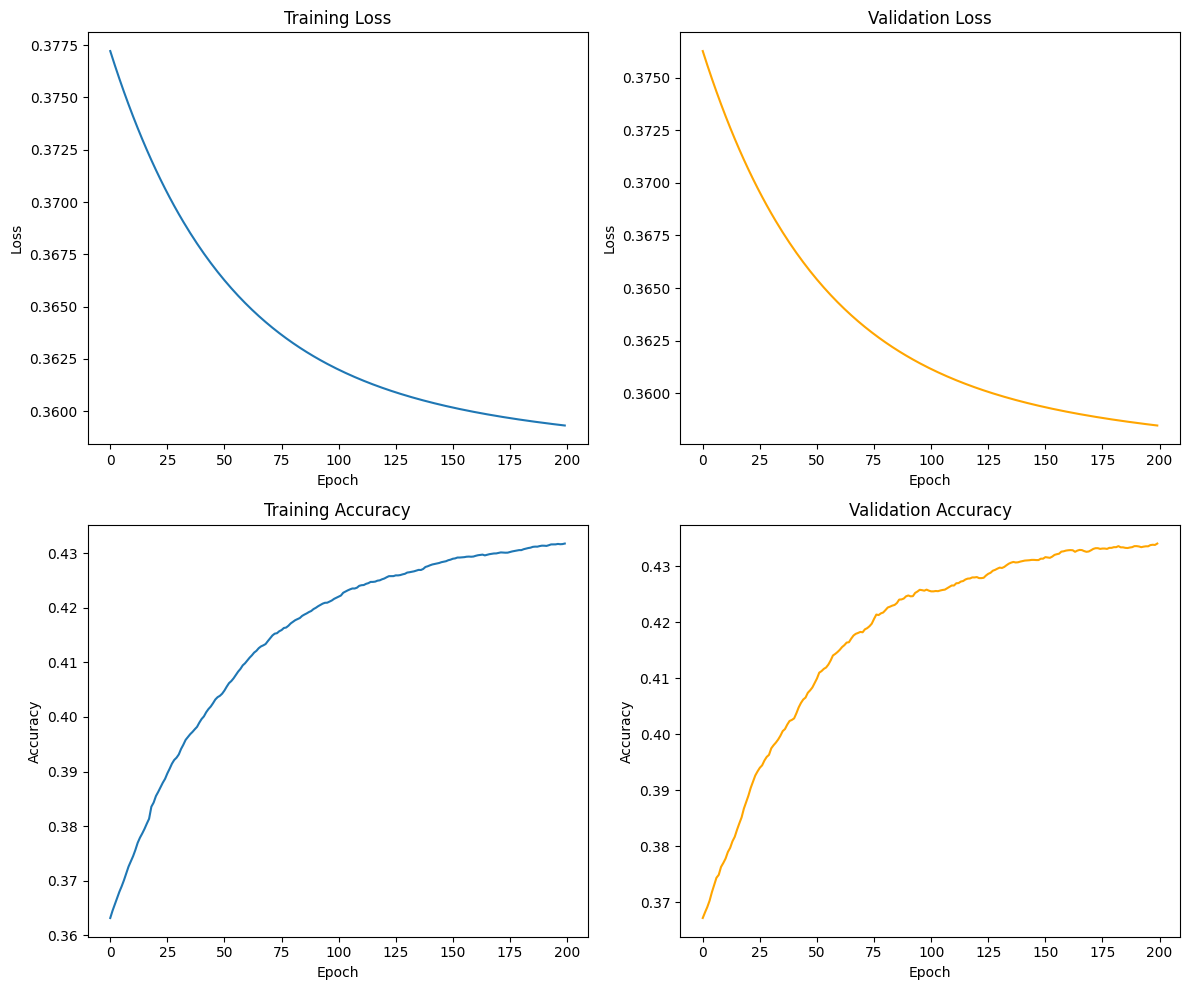

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [14]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set:')
print(f'val_acc: {val_set_acc:.3f}')
print(f'test_acc: {test_set_acc:.3f}')

Evaluation on validation and test set:
val_acc: 0.434
test_acc: 0.432
